In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
import cv2
import sklearn
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.utils.class_weight import compute_class_weight

In [2]:
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

In [3]:
img_size = 48

train_datagen = ImageDataGenerator(width_shift_range = 0.1,height_shift_range = 0.1,
                                    horizontal_flip = True,rescale = 1./255,
                                    validation_split = 0.2)

validation_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


In [4]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training")

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [5]:
class_indices = train_generator.class_indices  # Mapping of class names to indices
class_labels = list(class_indices.values())   # Class indices as a list
class_names = list(class_indices.keys())      # Class names as a list

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),  # Unique class labels
    y=train_generator.classes                   # Class labels from training data
)

# Convert to a dictionary (Keras expects a dictionary)
class_weights_dict = {class_label: weight for class_label, weight in zip(class_labels, class_weights)}
print("Class Weights:", class_weights_dict)

class_weights_dict[1] = min(class_weights_dict[1], 5.0)  # Cap extreme weights

for key in class_weights_dict:
    class_weights_dict[key] = max(0.5, min(class_weights_dict[key], 5.0))



Class Weights: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [6]:
from imblearn.over_sampling import RandomOverSampler

X_train, y_train = [], []
for X_batch, y_batch in train_generator:
    X_train.append(X_batch)
    y_train.append(y_batch)
    if len(X_train) * train_generator.batch_size >= len(train_generator.filenames):
        break  # Exit once we've collected enough data

# Convert lists to numpy arrays
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Perform oversampling
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)


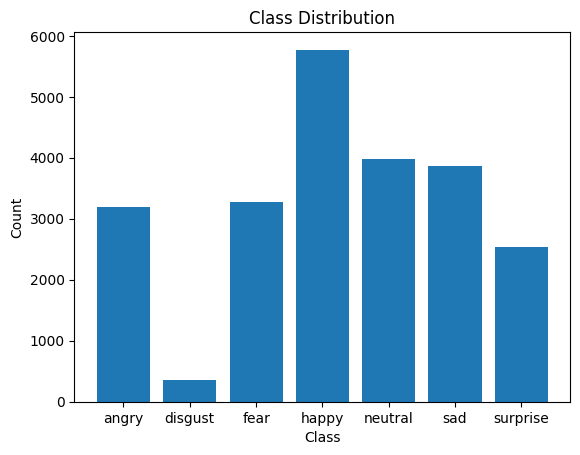

In [7]:
class_counts = np.bincount(train_generator.classes)

plt.bar(range(len(class_counts)), class_counts, tick_label=class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [8]:
model = tf.keras.Sequential([

        # input layer
        tf.keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape=(48,48,1)),
        tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu' ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),

        # 1st hidden dense layer
        tf.keras.layers.Conv2D(128,(5,5), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 2nd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # 3rd hidden dense layer
        tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.25),
    
        # Flatten layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
    
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),
        # output layer
        tf.keras.layers.Dense(7, activation='softmax')
    ])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,841,543 (14.65 MB)

 Trainable params: 3,837,575 (14.64 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [10]:
epochs = 50
batch_size = 64

In [11]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734015401.626073      83 service.cc:145] XLA service 0x7cfbb400aa00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734015401.626138      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734015401.626142      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  3/359 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.1918 - loss: 9.7545   

I0000 00:00:1734015416.257851      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/359 ━━━━━━━━━━━━━━━━━━━━ 70s 144ms/step - accuracy: 0.1575 - loss: 9.9225 - val_accuracy: 0.1592 - val_loss: 9.2369
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 82ms/step - accuracy: 0.1631 - loss: 9.7478 - val_accuracy: 0.2144 - val_loss: 9.1477
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.1755 - loss: 9.5927 - val_accuracy: 0.2297 - val_loss: 9.0251
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.1815 - loss: 9.4533 - val_accuracy: 0.2423 - val_loss: 8.9473
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.1878 - loss: 9.3451 - val_accuracy: 0.2465 - val_loss: 8.8536
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.1889 - loss: 9.2570 - val_accuracy: 0.2696 - val_loss: 8.7484
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - accuracy: 0.1884 - loss: 9.1452 - val_accuracy: 0.2723 - val_loss: 8.6690
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.2047 - loss: 9.0397 - val_accura

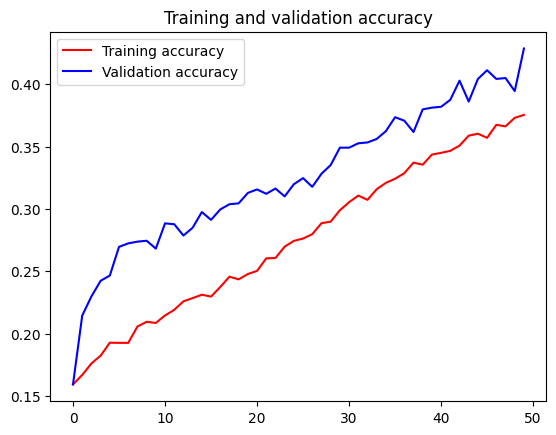

<Figure size 640x480 with 0 Axes>

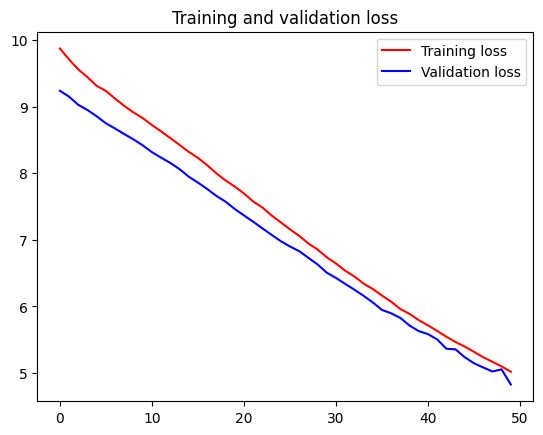

In [12]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [13]:
model.save('model_fer2013.h5')

In [14]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 29s 81ms/step - accuracy: 0.4305 - loss: 4.8362
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4267 - loss: 4.8234
final train accuracy = 43.26 , validation accuracy = 42.88


(48, 48)


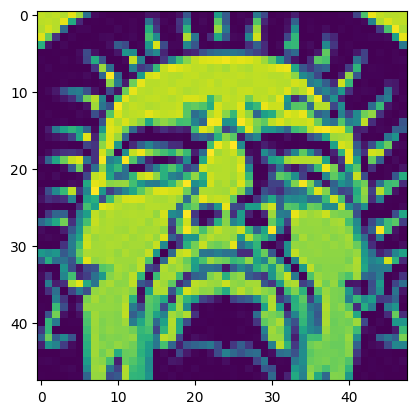

In [15]:
img = image.load_img("/kaggle/input/fer2013/test/fear/PrivateTest_1161501.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [16]:
Classes = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [17]:
img = np.expand_dims(img,axis = 0) 
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
img_index = result.index(max(result))
print(Classes[img_index])
plt.show()

Fear


In [19]:
model.save_weights('model_weights.weights.h5')

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


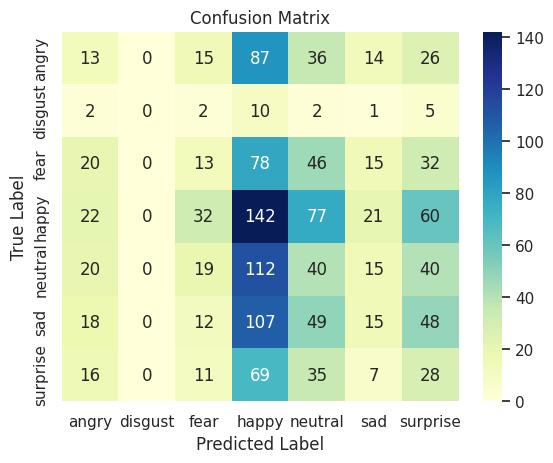

In [20]:
# Get the true labels and predicted labels for the validation set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred,axis=1)

y_true = validation_generator.classes

f1 = f1_score(y_true,y_pred_classes,average = 'weighted')
print(f"F1-Score (weighted): {f1:.2f}")

class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
F1-Score (weighted): 0.18
              precision    recall  f1-score   support

       angry       0.16      0.09      0.12       191
     disgust       0.00      0.00      0.00        22
        fear       0.17      0.09      0.12       204
       happy       0.24      0.40      0.30       354
     neutral       0.20      0.23      0.21       246
         sad       0.25      0.09      0.13       249
    surprise       0.13      0.19      0.16       166

    accuracy                           0.20      1432
   macro avg       0.16      0.16      0.15      1432
weighted avg       0.20      0.20      0.18      1432



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


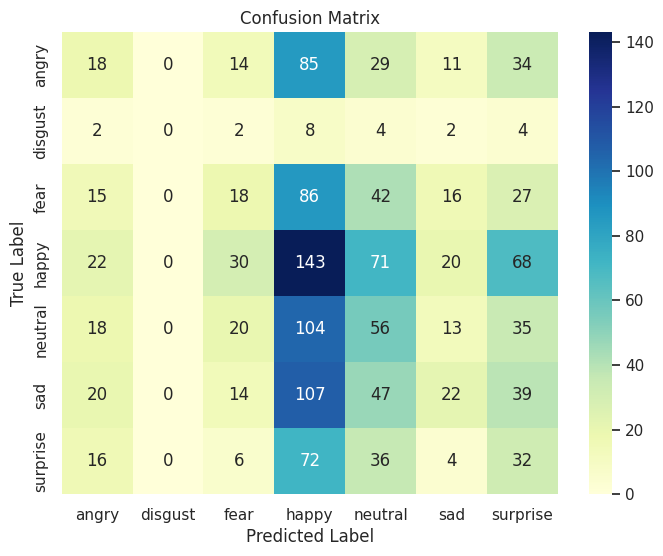

In [22]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_labels = list(validation_generator.class_indices.keys())

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()